<a href="https://colab.research.google.com/github/zahraDehghanian97/DenseNet_Vs._ResNet/blob/master/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mount google drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **prerequisit**

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing import image
from keras.layers import  Flatten, Dense, Input, Dropout 
import glob
from sklearn.model_selection import train_test_split
from keras.models import Sequential


# **call back**

In [3]:
class EarlyStoppingCallback(keras.callbacks.Callback):
  def __init__(self,patience=0):
    super(EarlyStoppingCallback,self).__init__()
    self.patience=patience
    self.best=np.Inf
    self.wait=0
    self.stopped_epoch=0
  def on_epoch_end(self,epoch,logs=None):
    current_loss=logs.get("val_loss")
    if np.less(current_loss,self.best):
      self.best=current_loss
      self.wait=0
      self.best_weights=self.model.get_weights()
    else:
      self.wait+=1
      print("\nwait mode, step: %d"% self.wait)
      if self.wait>=self.patience:
        self.stopped_epoch=epoch
        self.model.stop_training=True
        self.model.set_weights(self.best_weights)
        print("epoch: %d : early stopping."% self.stopped_epoch)
        self.wait = 0
      

es_callback=EarlyStoppingCallback(patience=5)

# **Make dataset ready**

In [4]:
def load_photos(type,dir_name):
    photo_list =[]
    y = []
    for file_name in (glob.glob(dir_name+'/*')):
        img = image.load_img(file_name, target_size=input_size)
        img = np.array(img)
        photo_list.append(img)
        y.append(type)
    return photo_list , y 
  
    
input_size = (250,250)
input_shape = (250,250,3)
dir_name_indoor = "/content/drive/MyDrive/Colab Notebooks/indoor"
dir_name_outdoor = "/content/drive/MyDrive/Colab Notebooks/outdoor"
X1 , y1= load_photos(0,dir_name_indoor) 
X2 , y2= load_photos(1,dir_name_outdoor) 
X1.extend(X2)
y1.extend(y2)
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.1, random_state=42)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
y_train = np.array(y_train)

# **DenseNet**

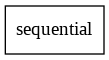

In [6]:
keras.backend.clear_session() 

base_model = keras.applications.DenseNet201(include_top=False, weights="imagenet",  input_shape=input_shape)
base_model.trainable  = False
model_dense = Sequential()
model_dense.add(base_model)
model_dense.add(Flatten())
model_dense.add(Dense(2500,activation='relu'))
model_dense.add(Dropout(0.2))
model_dense.add(Dense(1000,activation='relu'))
model_dense.add(Dropout(0.1))
model_dense.add(Dense(250,activation='relu'))
model_dense.add(Dense(50,activation='relu'))
model_dense.add(Dense(10,activation='relu'))
model_dense.add(Dense(2))
tf.keras.utils.plot_model(model_dense,show_shapes=True,expand_nested=True)


 

In [8]:
model_dense.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
tb_callback = keras.callbacks.TensorBoard(log_dir="./logs",histogram_freq=1)
model_dense.fit(X_train,y_train,epochs=1000,validation_split=0.2,callbacks=[es_callback,tb_callback])

prediction_without_fine_tune_dense =np.argmax(model_dense.predict(X_test),axis=1)

Epoch 1/1000
18/18 [==============================] - 223s 12s/step - loss: 16.9779 - accuracy: 0.7516 - val_loss: 0.7245 - val_accuracy: 0.8750
Epoch 2/1000
18/18 [==============================] - 205s 12s/step - loss: 0.3874 - accuracy: 0.8705 - val_loss: 0.8293 - val_accuracy: 0.6458

wait mode, step: 1
Epoch 3/1000
18/18 [==============================] - 220s 12s/step - loss: 0.2980 - accuracy: 0.7846 - val_loss: 0.8302 - val_accuracy: 0.5000

wait mode, step: 2
Epoch 4/1000
18/18 [==============================] - 215s 12s/step - loss: 0.2889 - accuracy: 0.8287 - val_loss: 1.4097 - val_accuracy: 0.8611

wait mode, step: 3
Epoch 5/1000
18/18 [==============================] - 213s 12s/step - loss: 0.3308 - accuracy: 0.9491 - val_loss: 0.4824 - val_accuracy: 0.8750
Epoch 6/1000
18/18 [==============================] - 228s 13s/step - loss: 0.3415 - accuracy: 0.9384 - val_loss: 2.4972 - val_accuracy: 0.8958

wait mode, step: 1
Epoch 7/1000
18/18 [==============================] - 2

##fine tune 

In [9]:
layers = base_model.layers
for layer in layers[-50:-1]:
  layer.trainable = True
model_dense_fine=keras.models.Sequential()
model_dense_fine.add(base_model)
for i in range(1,len(model_dense.layers)):
  model_dense_fine.add(model_dense.layers[i])
model_dense_fine.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
model_dense_fine.fit(X_train,y_train,epochs=1000,validation_split=0.2,callbacks=[es_callback])

Epoch 1/1000
18/18 [==============================] - 224s 12s/step - loss: 0.2804 - accuracy: 0.9514 - val_loss: 0.3971 - val_accuracy: 0.8819
Epoch 2/1000
18/18 [==============================] - 217s 12s/step - loss: 0.1125 - accuracy: 0.9601 - val_loss: 0.7936 - val_accuracy: 0.9028

wait mode, step: 1
Epoch 3/1000
18/18 [==============================] - 210s 12s/step - loss: 0.1595 - accuracy: 0.9670 - val_loss: 1.2882 - val_accuracy: 0.8889

wait mode, step: 2
Epoch 4/1000
18/18 [==============================] - 210s 12s/step - loss: 0.0668 - accuracy: 0.9792 - val_loss: 0.6676 - val_accuracy: 0.8889

wait mode, step: 3
Epoch 5/1000
18/18 [==============================] - 218s 12s/step - loss: 0.0482 - accuracy: 0.9878 - val_loss: 0.7413 - val_accuracy: 0.8819

wait mode, step: 4
Epoch 6/1000
18/18 [==============================] - 215s 12s/step - loss: 0.0474 - accuracy: 0.9844 - val_loss: 0.9795 - val_accuracy: 0.8819

wait mode, step: 5
epoch: 5 : early stopping.


In [10]:
prediction_fine_tune_dense=np.argmax(model_dense_fine.predict(X_test),axis=1)
print("DenseNet Result =====================>>>>")
print('accuracy without fine tuning = '+ str(accuracy_score(y_test,prediction_without_fine_tune_dense)))
print('confusion matrix without fine tuning'+ str( confusion_matrix(y_test,prediction_without_fine_tune_dense)))
print('accuracy with fine tuning = '+ str(accuracy_score(y_test,prediction_fine_tune_dense)))
print('confusion matrix with fine tuning'+ str( confusion_matrix(y_test,prediction_fine_tune_dense)))


DenseNet Result =====================>>>>
accuracy without fine tuning = 0.925
confusion matrix without fine tuning[[39  2]
 [ 4 35]]
accuracy with fine tuning = 0.9375
confusion matrix with fine tuning[[37  4]
 [ 1 38]]
